In [1]:
import torch
import datasets
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from datasets.load import load_dataset
from similarity import bert_cls_vectors_batched, bert_average_token_batched, tf_idf_vectorizer
from bert_classifier import BertClassifier, preprocess_nli_dataset
from common import device, bert_base

bert_classifier: torch.nn.Module

mnli_test: dict[str, torch.Tensor]
snli_test: dict[str, torch.Tensor]

Using CUDA device NVIDIA GeForce RTX 3090


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
print("Loading model...")
bert_classifier = BertClassifier(n_labels=3)
bert_classifier.load_state_dict(torch.load("finetuned_mnli.pt"))  # Path to fine-tuned BERT classifier
bert_classifier.eval()

print("Downloading datasets...")
mnli_test_ds: datasets.arrow_dataset.Dataset = load_dataset("multi_nli", split="validation_matched").with_format("pt")  # type: ignore
snli_test_ds: datasets.arrow_dataset.Dataset = load_dataset("snli", split="test").with_format("pt")  # type: ignore

with torch.no_grad():
    # Preprocess datasets by removing invalid data points and encoding inputs with BERT encoder
    print("Preprocessing datasets...")
    mnli_test_ds = preprocess_nli_dataset(mnli_test_ds, delete_text=False)
    snli_test_ds = preprocess_nli_dataset(snli_test_ds, delete_text=False)

    def convert_dataset_to_tensor_dict(dataset: datasets.arrow_dataset.Dataset) -> dict[str,torch.Tensor]:
        dataset = dataset.with_format("torch", device=device)
        return {column:dataset[column] for column in dataset.format["columns"]}
    mnli_test = convert_dataset_to_tensor_dict(mnli_test_ds)
    snli_test = convert_dataset_to_tensor_dict(snli_test_ds)

    print("Computing tf-idf vectors...")
    mnli_test["tfidf"] = tf_idf_vectorizer(premise=mnli_test["premise"], hypothesis=mnli_test["hypothesis"],  # type: ignore
        corpus=mnli_test["premise"]+mnli_test["hypothesis"]+snli_test["premise"]+snli_test["hypothesis"],  # type: ignore
        debug=True)
    snli_test["tfidf"] = tf_idf_vectorizer(premise=snli_test["premise"], hypothesis=snli_test["hypothesis"],  # type: ignore
        corpus=mnli_test["premise"]+mnli_test["hypothesis"]+snli_test["premise"]+snli_test["hypothesis"],  # type: ignore
        debug=True)
    assert mnli_test["tfidf"].size()[1] == snli_test["tfidf"].size()[1]

    bert_classifier.to(device)
    print("Computing CLS vectors of the finetuned classifier...")
    mnli_test["finetuned_cls"] = bert_cls_vectors_batched(bert_model=bert_classifier.bert,
        input_ids=mnli_test["input_ids"], attention_mask=mnli_test["attention_mask"],
        batch_size=64, debug=True)
    snli_test["finetuned_cls"] = bert_cls_vectors_batched(bert_model=bert_classifier.bert,
        input_ids=snli_test["input_ids"], attention_mask=snli_test["attention_mask"],
        batch_size=64, debug=True)
    print("Computing average token outputs of the finetuned classifier...")
    mnli_test["finetuned_avg"] = bert_average_token_batched(bert_model=bert_classifier.bert,
        input_ids=mnli_test["input_ids"], attention_mask=mnli_test["attention_mask"],
        batch_size=64, debug=True)
    snli_test["finetuned_avg"] = bert_average_token_batched(bert_model=bert_classifier.bert,
        input_ids=snli_test["input_ids"], attention_mask=snli_test["attention_mask"],
        batch_size=64, debug=True)
    bert_classifier.cpu()

    bert_base.to(device)
    print("Computing CLS vectors of the base BERT model...")
    mnli_test["base_cls"] = bert_cls_vectors_batched(bert_model=bert_base,
        input_ids=mnli_test["input_ids"], attention_mask=mnli_test["attention_mask"],
        batch_size=64, debug=True)
    snli_test["base_cls"] = bert_cls_vectors_batched(bert_model=bert_base,
        input_ids=snli_test["input_ids"], attention_mask=snli_test["attention_mask"],
        batch_size=64, debug=True)
    print("Computing average token outputs of the base BERT model...")
    mnli_test["base_avg"] = bert_average_token_batched(bert_model=bert_base,
        input_ids=mnli_test["input_ids"], attention_mask=mnli_test["attention_mask"],
        batch_size=64, debug=True)
    snli_test["base_avg"] = bert_average_token_batched(bert_model=bert_base,
        input_ids=snli_test["input_ids"], attention_mask=snli_test["attention_mask"],
        batch_size=64, debug=True)
    bert_base.cpu()

Loading model...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Found cached dataset multi_nli (/root/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39)
Found cached dataset snli (/root/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)
Loading cached processed dataset at /root/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39/cache-0acbc2286c4a9bd9.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39/cache-871ff5ebacac16e0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-9788f24186b0c7d7.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e

Preprocessing datasets...
Computing tf-idf vectors...
Computing CLS vectors of the finetuned classifier...


100%|██████████| 154/154 [00:14<00:00, 10.44it/s]


Computing average token outputs of the finetuned classifier...


100%|██████████| 154/154 [00:15<00:00,  9.88it/s]


Computing CLS vectors of the base BERT model...


100%|██████████| 154/154 [00:14<00:00, 10.30it/s]


Computing average token outputs of the base BERT model...


100%|██████████| 154/154 [00:15<00:00,  9.87it/s]


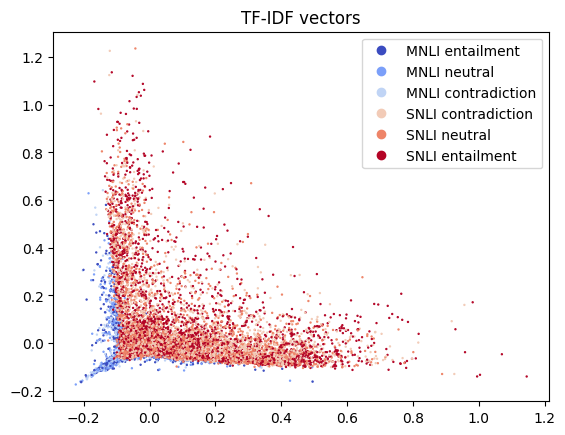

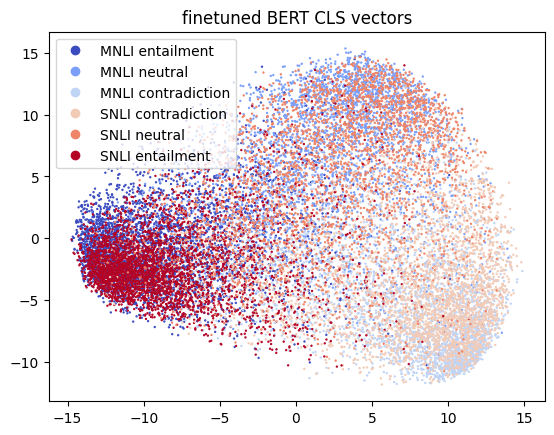

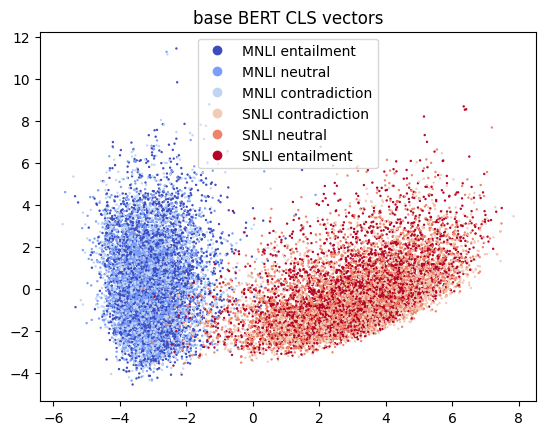

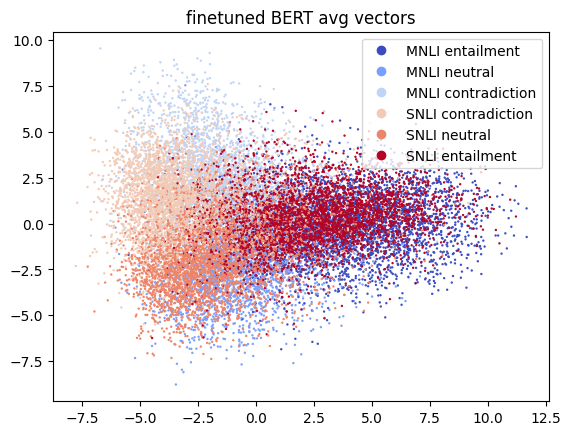

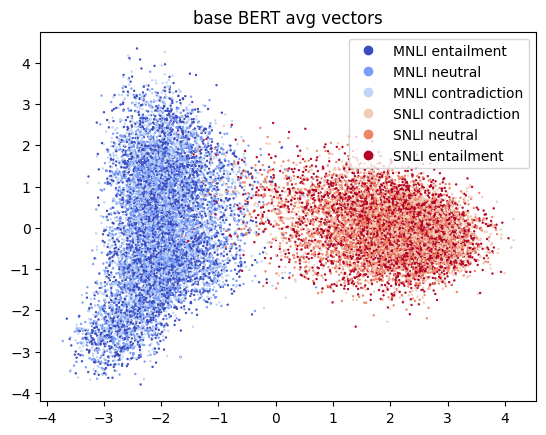

In [3]:
# Do PCA on labels
def plot_pca(cls_vectors: torch.Tensor, labels: torch.Tensor, title: str, label_names: list[str]):
    pca = PCA(n_components=2)
    cls_transform = pca.fit_transform(cls_vectors.cpu().numpy())
    plot = plt.scatter(cls_transform[:,0], cls_transform[:,1], c=labels.cpu().numpy(), s=0.5, cmap="coolwarm")
    plt.legend(handles=plot.legend_elements()[0], labels=label_names)
    plt.title(title)
    plt.show()

plot_pca(torch.cat((mnli_test["tfidf"], snli_test["tfidf"]), dim=0),
         torch.cat((mnli_test["label"], 5-snli_test["label"]), dim=0),
         title="TF-IDF vectors",
         label_names=["MNLI entailment", "MNLI neutral", "MNLI contradiction",
                      "SNLI contradiction", "SNLI neutral", "SNLI entailment"])
plot_pca(torch.cat((mnli_test["finetuned_cls"], snli_test["finetuned_cls"]), dim=0),
         torch.cat((mnli_test["label"], 5-snli_test["label"]), dim=0),
         title="finetuned BERT CLS vectors",
         label_names=["MNLI entailment", "MNLI neutral", "MNLI contradiction",
                      "SNLI contradiction", "SNLI neutral", "SNLI entailment"])
plot_pca(torch.cat((mnli_test["base_cls"], snli_test["base_cls"]), dim=0),
         torch.cat((mnli_test["label"], 5-snli_test["label"]), dim=0),
         title="base BERT CLS vectors",
         label_names=["MNLI entailment", "MNLI neutral", "MNLI contradiction",
                      "SNLI contradiction", "SNLI neutral", "SNLI entailment"])
plot_pca(torch.cat((mnli_test["finetuned_avg"], snli_test["finetuned_avg"]), dim=0),
         torch.cat((mnli_test["label"], 5-snli_test["label"]), dim=0),
         title="finetuned BERT avg vectors",
         label_names=["MNLI entailment", "MNLI neutral", "MNLI contradiction",
                      "SNLI contradiction", "SNLI neutral", "SNLI entailment"])
plot_pca(torch.cat((mnli_test["base_avg"], snli_test["base_avg"]), dim=0),
         torch.cat((mnli_test["label"], 5-snli_test["label"]), dim=0),
         title="base BERT avg vectors",
         label_names=["MNLI entailment", "MNLI neutral", "MNLI contradiction",
                      "SNLI contradiction", "SNLI neutral", "SNLI entailment"])

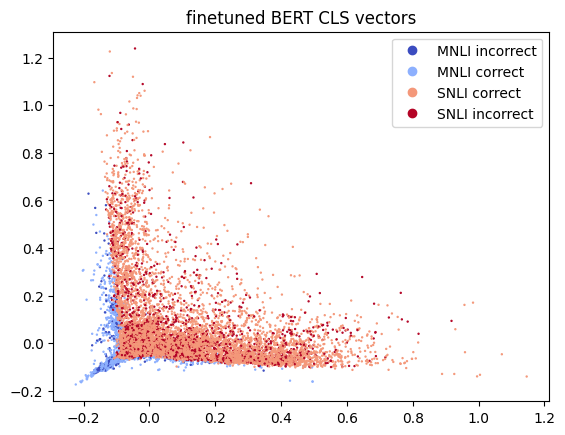

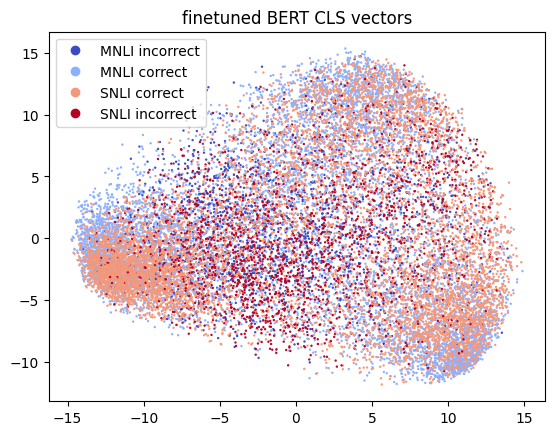

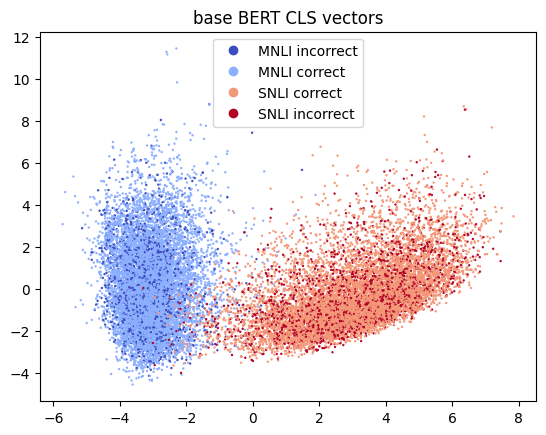

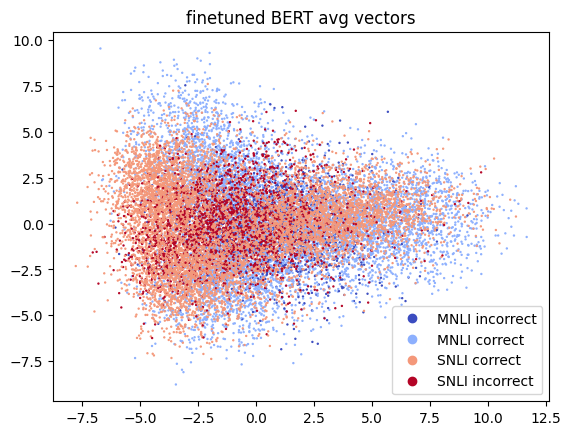

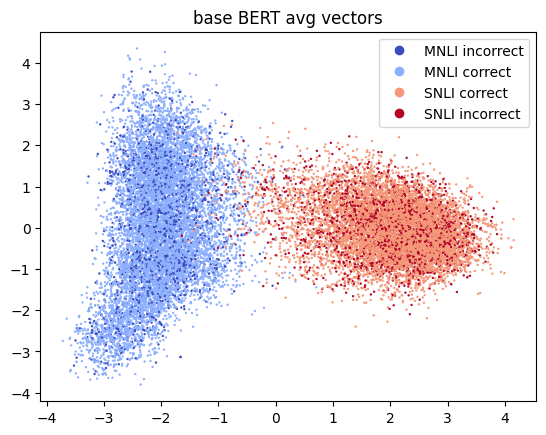

In [4]:
# Do PCA on correct/incorrect predictions
def compute_correctly_classified(classifier: torch.nn.Module, dataset: dict[str, torch.Tensor], debug: bool = False):
    """
    Add a new boolean field 'is_correct' to the dataset indicating whether the classifier
    predicted the label correctly
    """
    dataset_size = len(dataset["label"])
    batch_size = 64
    dataset["is_correct"] = torch.empty_like(dataset["label"], dtype=torch.bool, device=device)

    for batch_indices in torch.split(torch.arange(dataset_size, device=device), batch_size):
        target = dataset["label"][batch_indices].to(device)
        output = classifier.forward(dataset["input_ids"][batch_indices].to(device),
            dataset["attention_mask"][batch_indices].to(device))
        predictions = output.argmax(dim=1, keepdim=True).squeeze()
        is_correct = torch.eq(target, predictions)
        if debug:
            if target.size() != (len(batch_indices),):
                raise AssertionError(f"target size: {target.size()}")
            if output.size() != (len(batch_indices), classifier.num_labels):
                raise AssertionError(f"output size: {output.size()}")
            if predictions.size() != (len(batch_indices),):
                raise AssertionError(f"predictions size: {predictions.size()}, ")
            if is_correct.size() != (len(batch_indices),):
                raise AssertionError(f"is_correct size: {is_correct.size()}, ")
        dataset["is_correct"][batch_indices] = is_correct

bert_classifier.to(device)
compute_correctly_classified(classifier=bert_classifier, dataset=mnli_test)
compute_correctly_classified(classifier=bert_classifier, dataset=snli_test)
bert_classifier.cpu()

plot_pca(torch.cat((mnli_test["tfidf"], snli_test["tfidf"]), dim=0),
         torch.cat((mnli_test["is_correct"], ~snli_test["is_correct"]+3), dim=0),
         title="finetuned BERT CLS vectors",
         label_names=["MNLI incorrect", "MNLI correct", "SNLI correct", "SNLI incorrect"])
plot_pca(torch.cat((mnli_test["finetuned_cls"], snli_test["finetuned_cls"]), dim=0),
         torch.cat((mnli_test["is_correct"], ~snli_test["is_correct"]+3), dim=0),
         title="finetuned BERT CLS vectors",
         label_names=["MNLI incorrect", "MNLI correct", "SNLI correct", "SNLI incorrect"])
plot_pca(torch.cat((mnli_test["base_cls"], snli_test["base_cls"]), dim=0),
         torch.cat((mnli_test["is_correct"], ~snli_test["is_correct"]+3), dim=0),
         title="base BERT CLS vectors",
         label_names=["MNLI incorrect", "MNLI correct", "SNLI correct", "SNLI incorrect"])
plot_pca(torch.cat((mnli_test["finetuned_avg"], snli_test["finetuned_avg"]), dim=0),
         torch.cat((mnli_test["is_correct"], ~snli_test["is_correct"]+3), dim=0),
         title="finetuned BERT avg vectors",
         label_names=["MNLI incorrect", "MNLI correct", "SNLI correct", "SNLI incorrect"])
plot_pca(torch.cat((mnli_test["base_avg"], snli_test["base_avg"]), dim=0),
         torch.cat((mnli_test["is_correct"], ~snli_test["is_correct"]+3), dim=0),
         title="base BERT avg vectors",
         label_names=["MNLI incorrect", "MNLI correct", "SNLI correct", "SNLI incorrect"])